In [13]:
import numpy as np
import cvxpy as cp
import json
from matplotlib import pyplot as plt 

In [2]:
def nearestPointsOnCurve(X, P, M, W):
	# t = 0:0.0001:1
	t = np.array(range(0,10001,1))/10000
	# print(np.ones((len(t))).shape)
	# print(t.shape)
	Z = np.c_[np.ones((len(t))),t,np.square(t),np.power(t,3)]
	Z = Z.T
	# Z = np.array([np.ones((1,len(t))), t, np.square(t), np.pow(t,3)]).reshape((-1,1))
	# print(P.shape)
	# print(M.shape)
	# print(Z.shape)
	bzc = np.dot(np.dot(P,M),Z)
	# print(X)
	# print(bzc.shape[1])
	distsq = np.zeros((len(t),X.shape[1]))
	for i in range(X.shape[0]):
		idelta = np.zeros((bzc.shape[1],X.shape[1]))
		for a in range(bzc.shape[1]):
			for b in range(X.shape[1]):
				idelta[a,b] = bzc[i,a] - X[i,b]
		# idelta = np.subtract(np.repeat(bzc[i,:].T, X.shape[1],axis=1),np.repeat(X[i,:],bzc.shape[1]))
		distsq = distsq + W[i] * np.square(idelta)
	# print(distsq.shape)
	k = np.argmin(distsq,axis=0)
	# k = np.where(distsq==dists)
	# print(k.shape)
	s=[]
	msedist = 0.0
	pc = []
	for i in range(len(k)):
		r = k[i]
		s.append(t[r])
		msedist = msedist + distsq[r,i]
		pc.append(bzc[:,r])
	s=np.array(s)
	# print(s)
	pc = np.array(pc).T

	# pc = bzc[:,k].T
	# s = t[k]
	# msedist = np.sum(dists)
	return [msedist, pc, s]

In [3]:
def PCA_ranking(X,alpha,W,AttriNum,M):
	[mse, Pt, St, optFlag] = PCAlgorithm(X,alpha,W,AttriNum,M)
	while optFlag==0:
		print('re-sorting')
		[mse, Pt, St, optFlag] = PCAlgorithm(X,alpha,W,AttriNum,M)
	return [mse, Pt, St]

def PCAlgorithm(X,alpha,W,AttriNum,M):

	optFlag = 1
	P00 = 0.5*(1 - alpha)
	P03 = 0.5*(1 + alpha)
	Pt = np.c_[P00, np.random.rand((AttriNum)), np.random.rand((AttriNum)), P03]
	# print(Pt.shape)
	[lastmse, temp, St] = nearestPointsOnCurve(X, Pt, M,W);
	deltaM = 10000

	while deltaM > 0.00001:
		Zt = np.c_[np.ones((X.shape[1])), St, np.square(St), np.power(St,3)]
		# print(Zt.shape)
		# print(M.T.shape)

		p = cp.Variable((4,AttriNum))
		# print(np.dot(Zt,M.T).shape)
		# print(np.dot(np.dot(Zt,M.T),p).shape)
		A = np.dot(Zt,M.T)
		objective = cp.Minimize(sum((A@p-X.T)**2@W))
		constraints = [0 <= p, p <= 1,np.array([1,0,0,0])@p==P00.T,np.array([0,0,0,1])@p==P03.T]
		prob = cp.Problem(objective, constraints)
		result = prob.solve()

		# Pt = getControlPoints(Zt, M, X, P00, P03, W,attriNum);
		Pt = p.value.T
		# print(Pt)
		[mse, temp, St] = nearestPointsOnCurve(X, Pt, M, W);
		deltaM =  lastmse - mse;
		if deltaM<0:
			optFlag = 0
			break
		lastmse = mse
	return [mse, Pt, St,optFlag]


In [33]:
def plot_curves(s,X,AttriNum,weights):
    s_sorted = np.sort(s)
    indices = np.argsort(s)
    print(indices)
    curves = [];
    AttrName = [];

    for i in range(AttriNum):
        a = X[i,:]
        a = a[indices]
        p, = plt.plot(a)
        curves.append(p)
        AttrName.append("Attribution "+str(i+1)+" (weight: "+ str(weights[i])+")")

    p0, = plt.plot(s_sorted)

    legend = plt.legend([p0]+curves,["Cubic Bezier Curve"]+AttrName)

    plt.show()

In [24]:
def main(u,AttriNum,weights,plot):
	if(len(weights)!=AttriNum):
		print("The number of weights should be consistent with the the number of attributions.")
		exit()

	coeff = np.array([-0.7])
	n = 20
	W = np.array(weights).T
	
	M = np.array([[1,-3,3,-1],[0, 3, -6, 3],[0, 0, 3, -3],[0, 0, 0, 1]])

	# random2dAttrbuteValues(coeff,n)
	# [u, temp] = rv.random2dAttributeValues(coeff, n);
# 	u = np.random.random((AttriNum,20))
	# X = u.reshape((-1,1))
	X = u

	alpha = np.array([1]*AttriNum).T
	if(coeff<0):
		alpha[1]=-1

	[temp, controlPoints, score] = PCA_ranking(X,alpha,W,AttriNum,M)

	[temp, pc, s] = nearestPointsOnCurve(X, controlPoints, M, W);

	if(plot==True):
		plot_curves(s,X,AttriNum,weights)


[18  3  9 12 15  6 10  8 13  4  7 17  0  1 19 14  5  2 16 11]


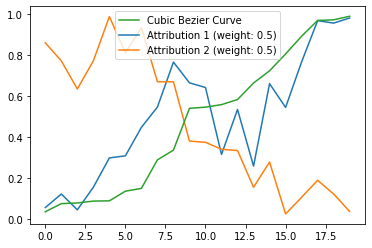

In [34]:
with open("products.json",'r') as load_f:
    products = json.load(load_f)['products']
    AttriNum = len(products['1']['attributions'])
    attrs = []
    for i in range(AttriNum):
        attr = []
        for j in products:
            attr.append(products[j]['attributions'][i])
        attrs.append(attr)
        
main(np.array(attrs),AttriNum,[0.5,0.5],True)